# Imports

In [1]:
import time
import json
import numpy as np
import pandas as pd
from pandas import json_normalize

import datetime

import seaborn as sns
import matplotlib.pyplot as plt

from tabulate import tabulate
from IPython.core import display as ICD

import lightgbm as lgb

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

from google.colab import drive
drive.mount("/content/drive")
drive_dir = '/content/drive/My Drive/'

Mounted at /content/drive


In [2]:
url = 'https://raw.githubusercontent.com/kaus0399/Applied_Regression_Project_1/main/final_data.csv?token=AOLVKLOI3X7FM6D5UBDPNLLBQ5S4E'
df = pd.read_csv(url)
df.head()

,Unnamed: 0,geoNetwork.country,fullVisitorId,channelGrouping,fullVisitorId.1,device.browser,device.operatingSystem,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country.1,trafficSource.source,trafficSource.medium,totals.hits,totals.pageviews,date,trafficSource.adContent,device.isMobile,avgGDP,gni2017,gni_cat,totals.transactionRevenue,summedRevenue,summedRevenue_log,totals.transactionRevenue_log
0,1,Other,4.068234e+18,Organic Search,4.068234e+18,Chrome,iOS,desktop,Americas,South America,Argentina,google,organic,20,14,20170529,NaN,False,23182.014585,13140,High income,63060000.0,63060000.0,17.959597,17.959597
1,2,Other,1.226456e+18,Paid Search,1.226456e+18,Chrome,Windows,desktop,Oceania,Australasia,Australia,google,cpc,33,31,20161112,NaN,False,48610.589120,51560,High income,15980000.0,15980000.0,16.586848,16.586848
2,3,Other,5.879552e+18,Organic Search,5.879552e+18,Chrome,iOS,desktop,Americas,South America,Brazil,google,organic,19,19,20161030,NaN,False,14548.007516,8700,High-Middle income,37980000.0,37980000.0,17.452570,17.452570
3,4,Canada,6.783650e+18,Organic Search,6.783650e+18,Chrome,Windows,desktop,Americas,Northern America,Canada,google,organic,42,34,20161030,NaN,False,48190.498569,42900,High income,43470000.0,43470000.0,17.587582,17.587582
4,5,Canada,7.283027e+17,Organic Search,7.283027e+17,Chrome,Chrome OS,desktop,Americas,Northern America,Canada,google,organic,38,30,20170111,NaN,False,48190.498569,42900,High income,7970000.0,7970000.0,15.891195,15.891195


# Basic Exploration

In [3]:
df.shape

(1335, 25)

In [4]:
df.columns

Index(['Unnamed: 0', 'geoNetwork.country', 'fullVisitorId', 'channelGrouping',
       'fullVisitorId.1', 'device.browser', 'device.operatingSystem',
       'device.deviceCategory', 'geoNetwork.continent',
       'geoNetwork.subContinent', 'geoNetwork.country.1',
       'trafficSource.source', 'trafficSource.medium', 'totals.hits',
       'totals.pageviews', 'date', 'trafficSource.adContent',
       'device.isMobile', 'avgGDP', 'gni2017', 'gni_cat',
       'totals.transactionRevenue', 'summedRevenue', 'summedRevenue_log',
       'totals.transactionRevenue_log'],
      dtype='object')

Each row in the dataset is one visit to the Google store. We are planning to predict the natural log of the sum of all transactions per user.

The given variables in the dataset are:

- geoNetwork - This section contains information about the geography of the user.
- fullVisitorId - A unique identifier for each user of the Google Merchandise Store.
- channelGrouping - The channel via which the user came to the Store.
- device - The specifications for the device used to access the Store.
- trafficSource - his section contains information about the Traffic Source from which the session originated.
- totals - This section contains aggregate values across the session.
- date - The date on which the user visited the Store.
- avgGDP - the GDP for the country
- gni2017 - the gross national income for the country in 2017
- gni_cat - the gross national income listed as "high income", "high-middle income", or "low-middle income"
- summedRevenue - the sum of total revenue
- summedRevenue_log - the log of the sum of total revenue (what we are trying to predict)

In [5]:
df.dtypes

Unnamed: 0                         int64
geoNetwork.country                object
fullVisitorId                    float64
channelGrouping                   object
fullVisitorId.1                  float64
device.browser                    object
device.operatingSystem            object
device.deviceCategory             object
geoNetwork.continent              object
geoNetwork.subContinent           object
geoNetwork.country.1              object
trafficSource.source              object
trafficSource.medium              object
totals.hits                        int64
totals.pageviews                   int64
date                               int64
trafficSource.adContent           object
device.isMobile                     bool
avgGDP                           float64
gni2017                            int64
gni_cat                           object
totals.transactionRevenue        float64
summedRevenue                    float64
summedRevenue_log                float64
totals.transacti

In [6]:
for c in df.columns:
    n_missing = df[c].isna().sum()
    pct_missing = n_missing / df.shape[0]
    if n_missing > 0:
      print(f'{c}: {n_missing} ({100*pct_missing:.2f}%) missing values')

trafficSource.adContent: 1317 (98.65%) missing values


# Exploratory Data Analysis

## Histograms

In [34]:
cat_df = df[['geoNetwork.country', 'channelGrouping', 'device.browser', 'device.operatingSystem', 'device.deviceCategory', 'geoNetwork.continent', 
           'trafficSource.source', 'trafficSource.medium', 'trafficSource.adContent', 'device.isMobile', 'gni_cat']]
num_df = df[['totals.hits', 'totals.pageviews', 'avgGDP', 'gni2017', 'totals.transactionRevenue', 'summedRevenue', 'summedRevenue_log', 'totals.transactionRevenue_log']]

In [8]:
sns.set(font_scale = 1.5)

def hist_func(c):
  fig, ax = plt.subplots()
  fig.set_size_inches(15, 10)
  hist = sns.histplot(data=df, x=c)
  hist.set_title("Histogram of " + c)

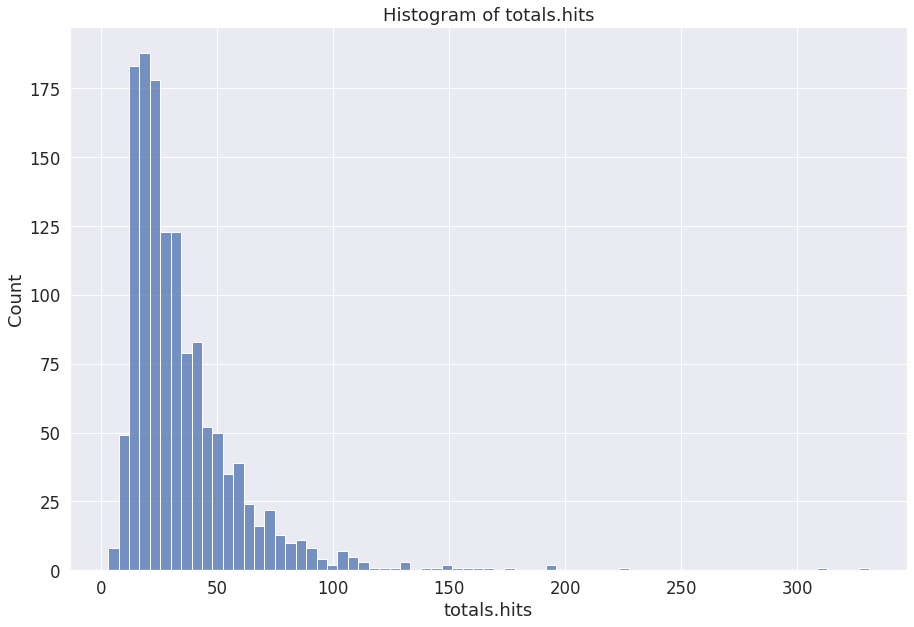

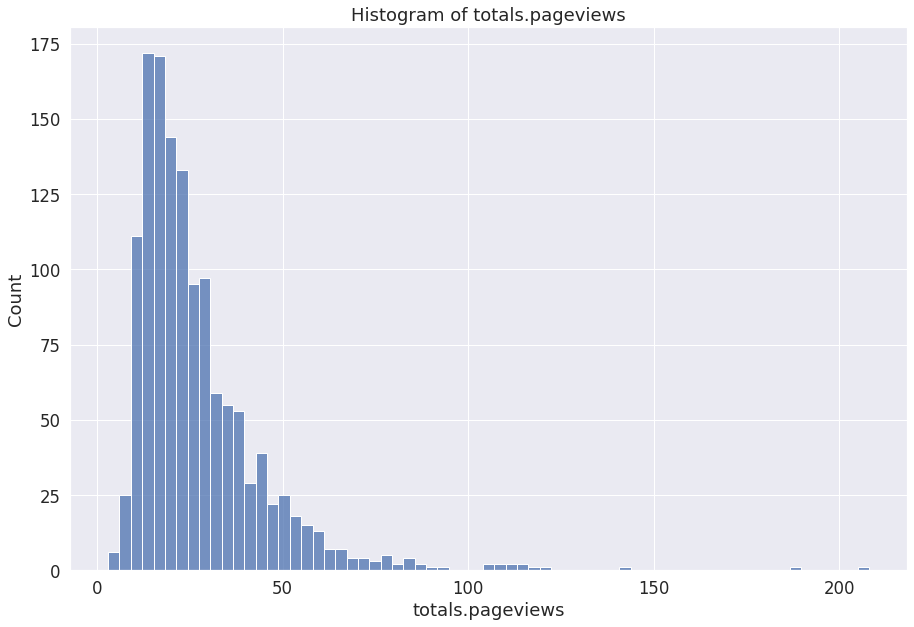

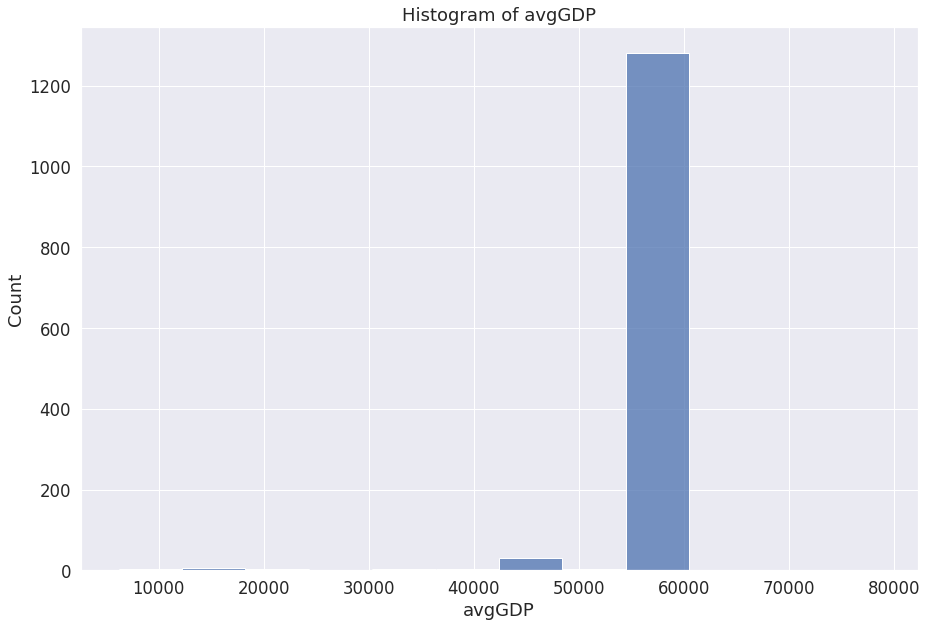

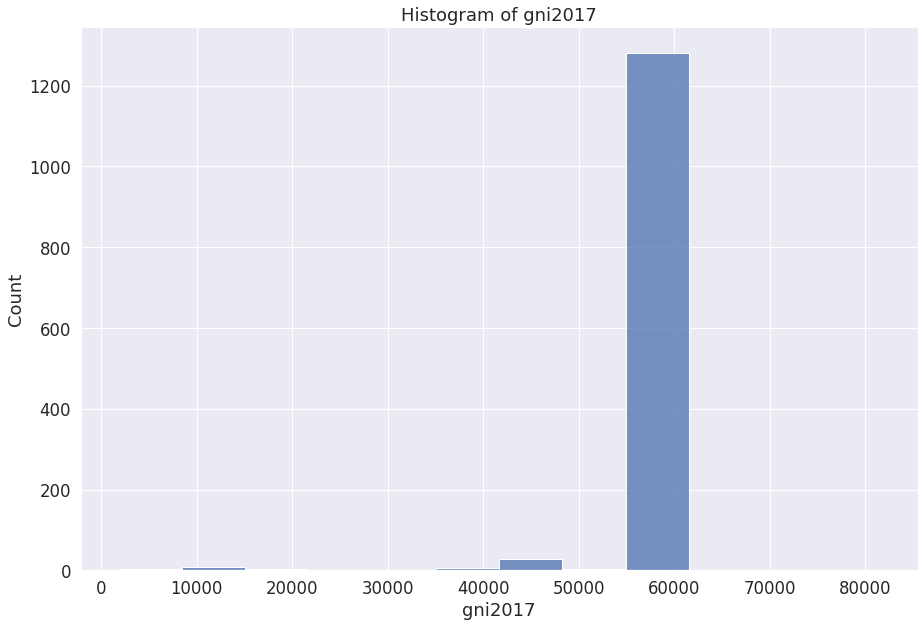

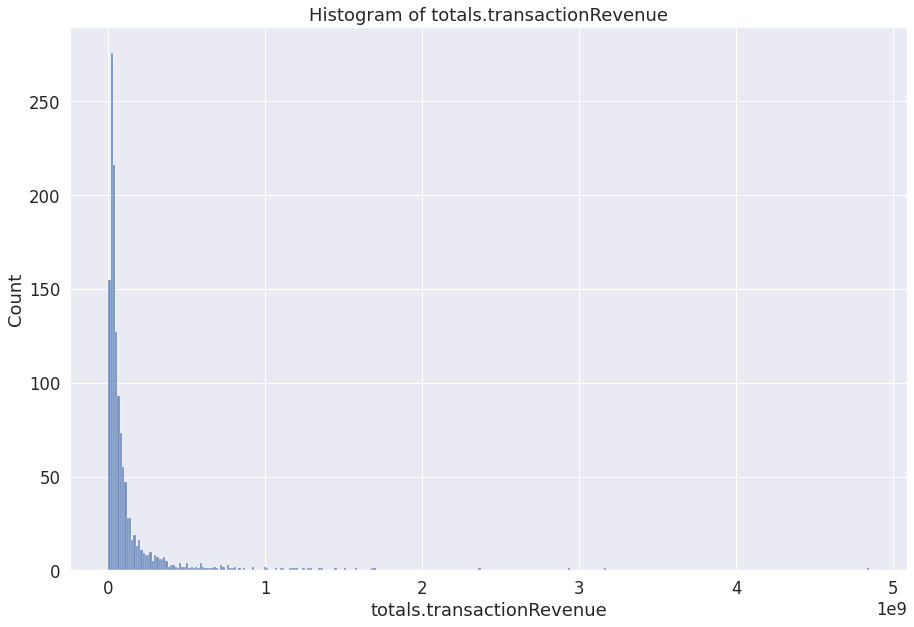

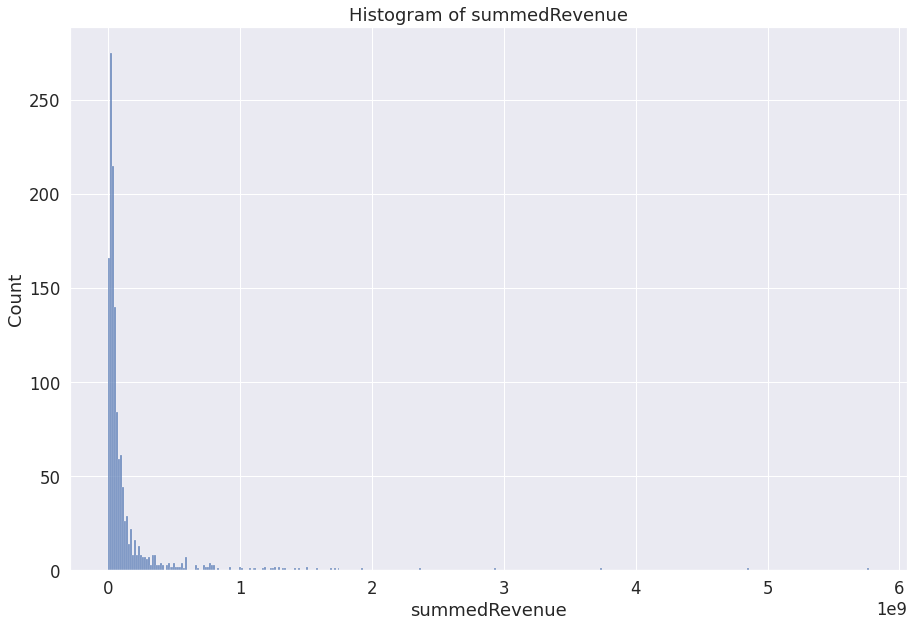

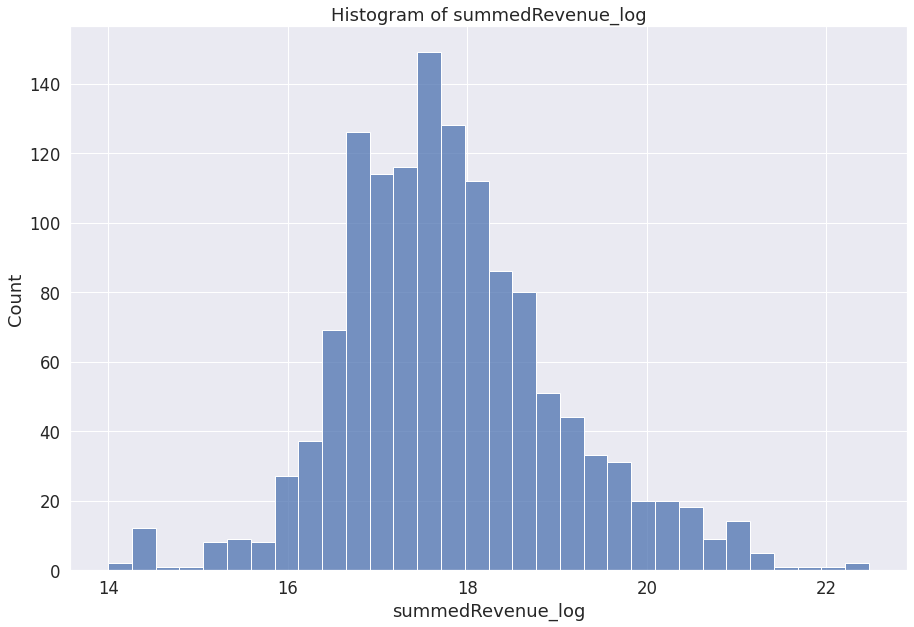

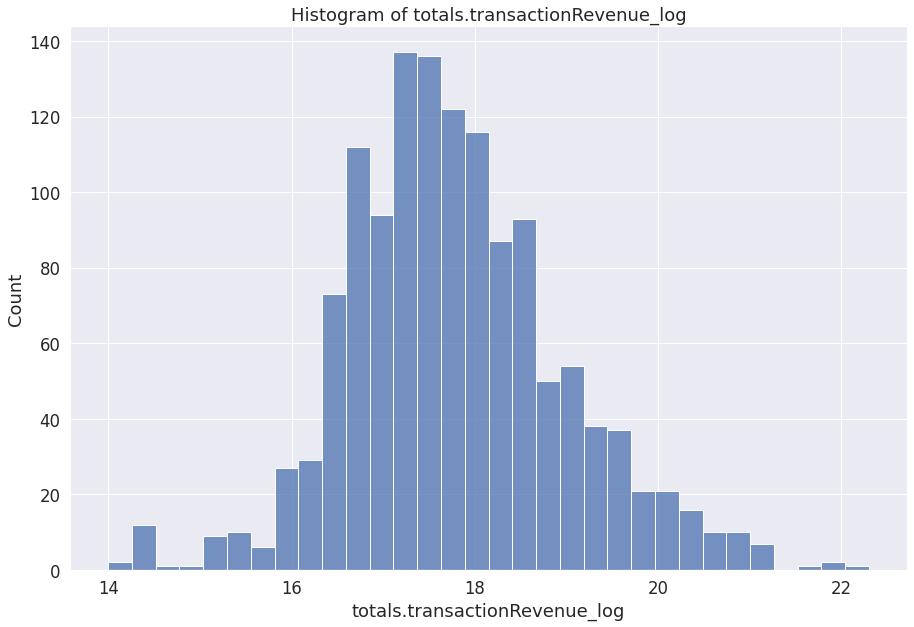

In [9]:
for c in num_df:
  hist_func(c)

`totals.hits`, `total.pageviews` are right skewed with the highest occurrances around 20 hits and 20 pageviews. `totals.transactionRevenue` and `summedRevenue` are also right skewed but log transforming them results in a normal distribution.

## Correlation Matrix

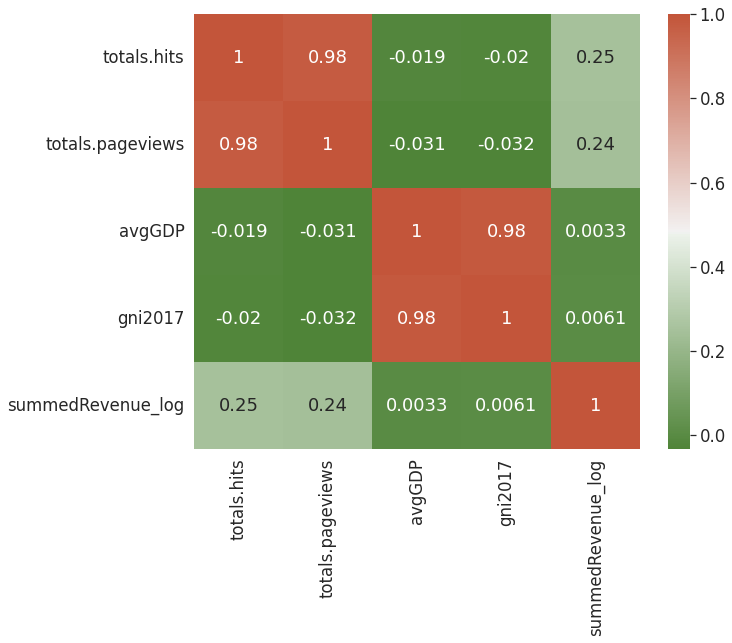

In [10]:
numer_corr = df[['totals.hits', 'totals.pageviews', 'avgGDP', 'gni2017', 'summedRevenue_log']]
plt.figure(figsize=(10, 8))
corr_matrix = numer_corr.corr()
cmap_diverging = sns.diverging_palette(120, 20, as_cmap=True)
sns.heatmap(corr_matrix,
            xticklabels=corr_matrix.columns.values,
            yticklabels=corr_matrix.index.values,
            cmap = cmap_diverging,
            annot = True)

As we can see from the correlation matrix above, `totals.hits` and `totals.pageviews` are highly correlated, indicating multicollinearity. The same goes for `avgGDP` and `gni2017`. It would be wise to either combine the variables or only include one once we start modeling. Moreover, `totals.hits` and `totals.pageviews` seem to have the highest correlation with our outcome variable, `summedRevenue_log`.

## Boxplots

In [56]:
def make_boxplot(x):  
  fig, ax = plt.subplots()
  fig.set_size_inches(15, 10)
  boxplt = sns.boxplot(data=df, x=x, y = 'summedRevenue_log')
  boxplt.set_title("Boxplot of " + x)

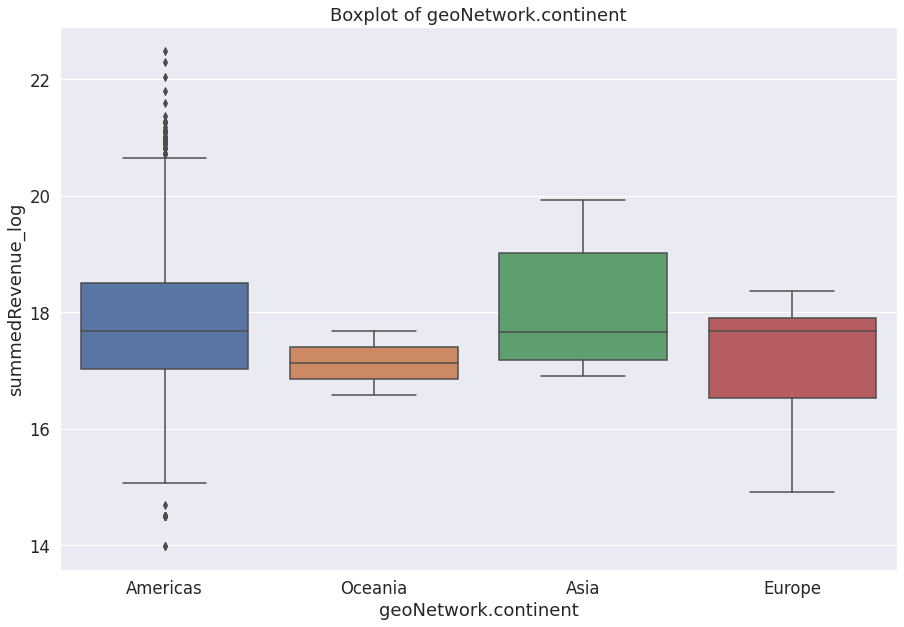

In [57]:
make_boxplot('geoNetwork.continent')

All continents besides Oceania have similar median values for `summedRevenue_log`. Asia and Europe in particular have skewed distributions. There are outliers in the Americas group. 

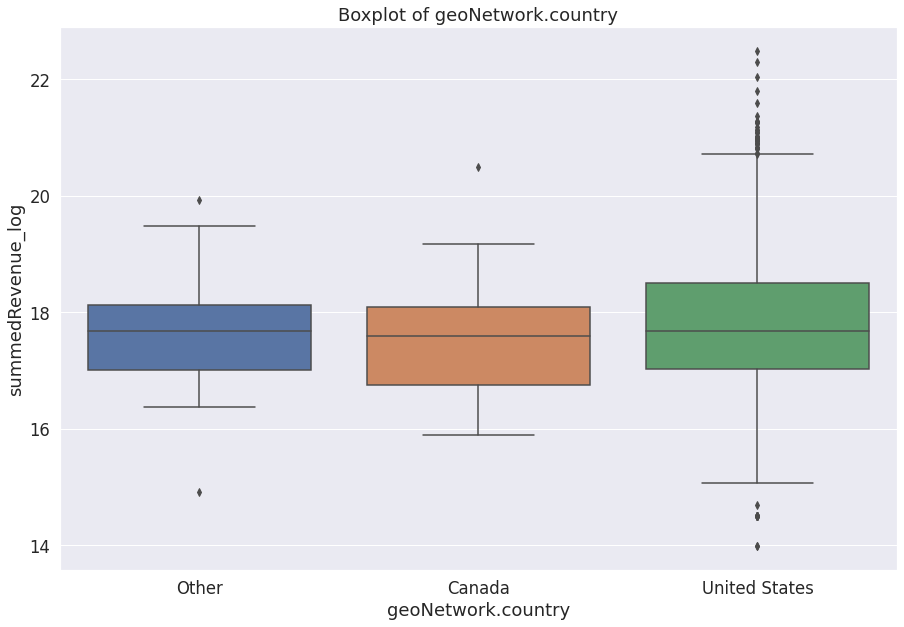

In [58]:
make_boxplot('geoNetwork.country')

The countries all have similar median values but the US has the highest number of outliers and the highest max and lowest min.

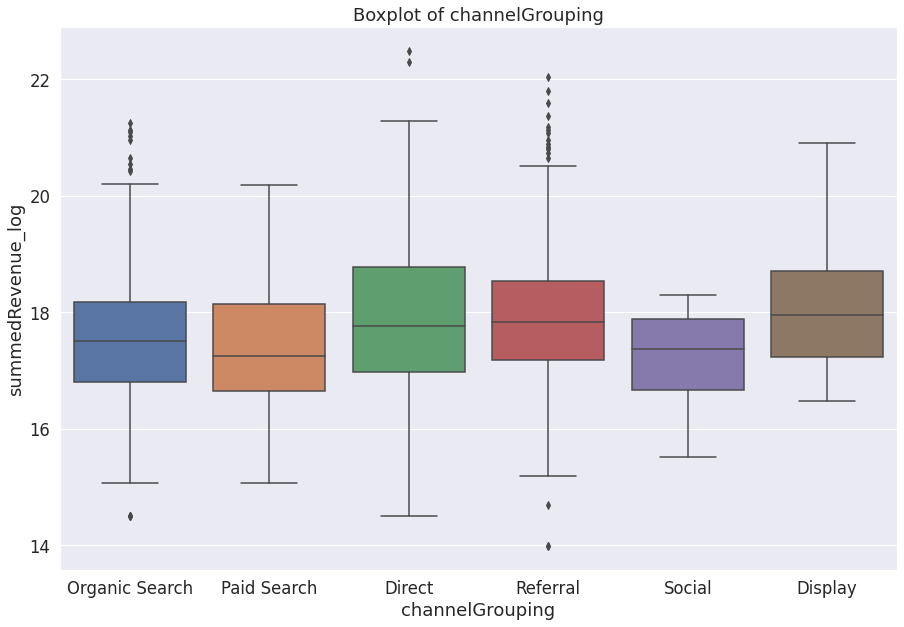

In [43]:
make_boxplot('channelGrouping')

Display has the highest median value for `summedRevenue_log` but barely.

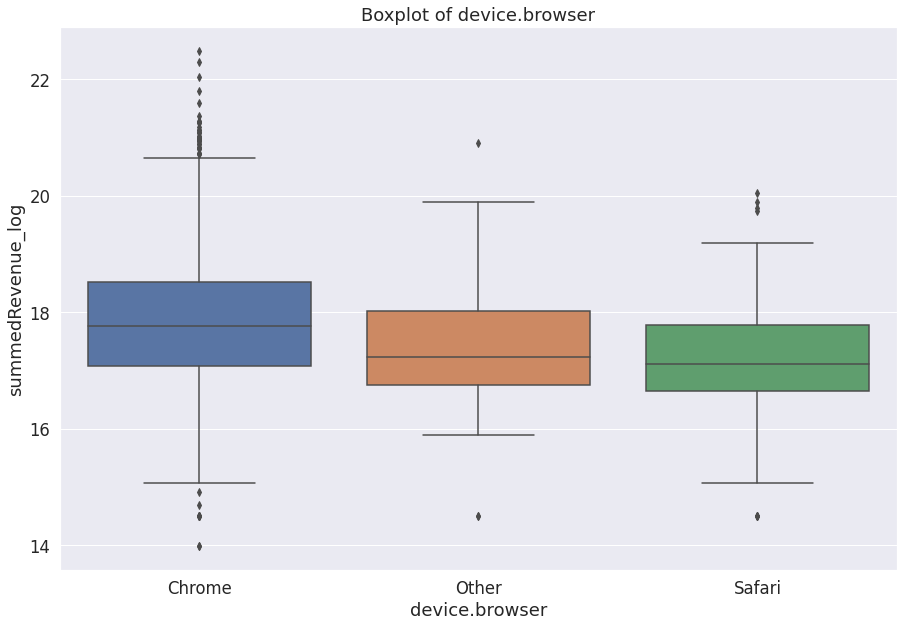

In [44]:
make_boxplot('device.browser')

Chrome has the highest median value for `summedRevenue_log` and also the most outliers and the widest distribution.

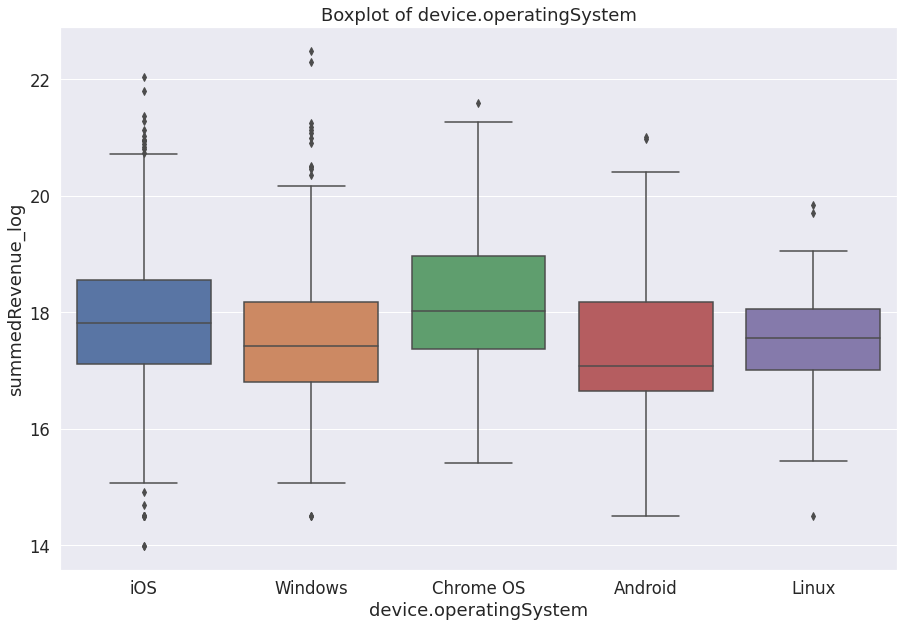

In [45]:
make_boxplot('device.operatingSystem')

Chrome again has the highest median value for `summedRevenue_log`. This and the previous boxplot may reveal some sort of pattern regarding chrome users and how much they spend at the google store.

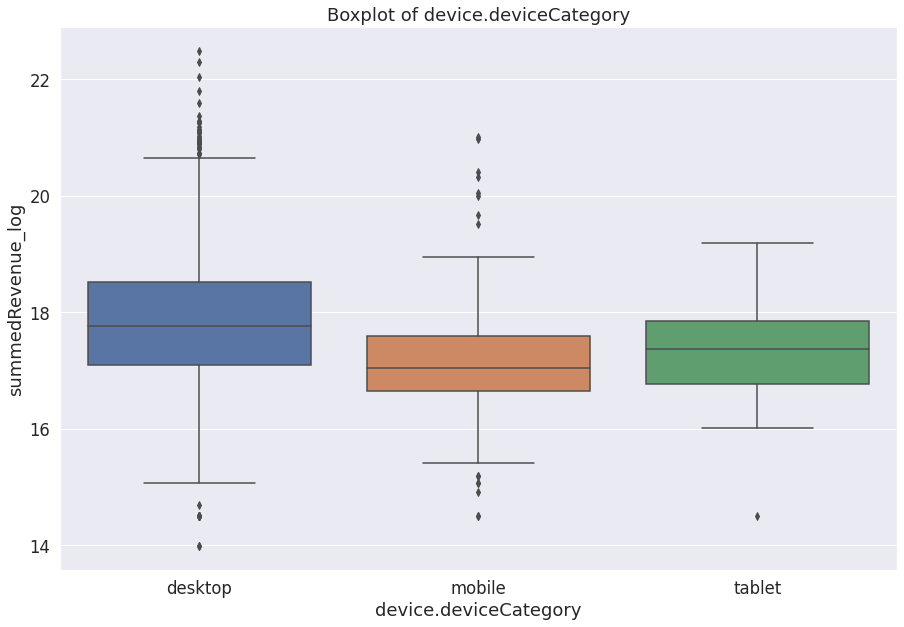

In [46]:
make_boxplot('device.deviceCategory')

Desktop users have the highest median followed by tablet users and mobile users.

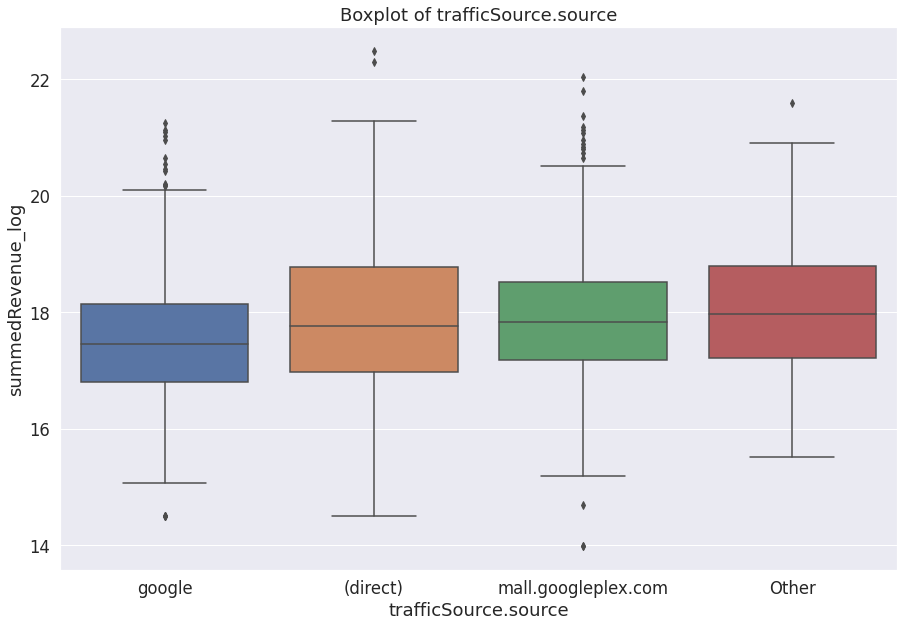

In [48]:
make_boxplot('trafficSource.source')

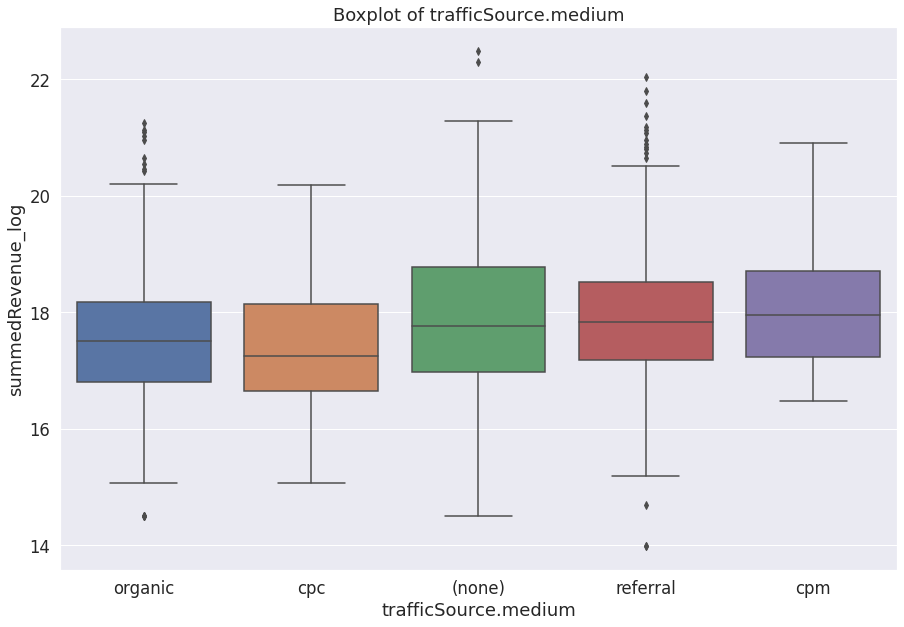

In [49]:
make_boxplot('trafficSource.medium')

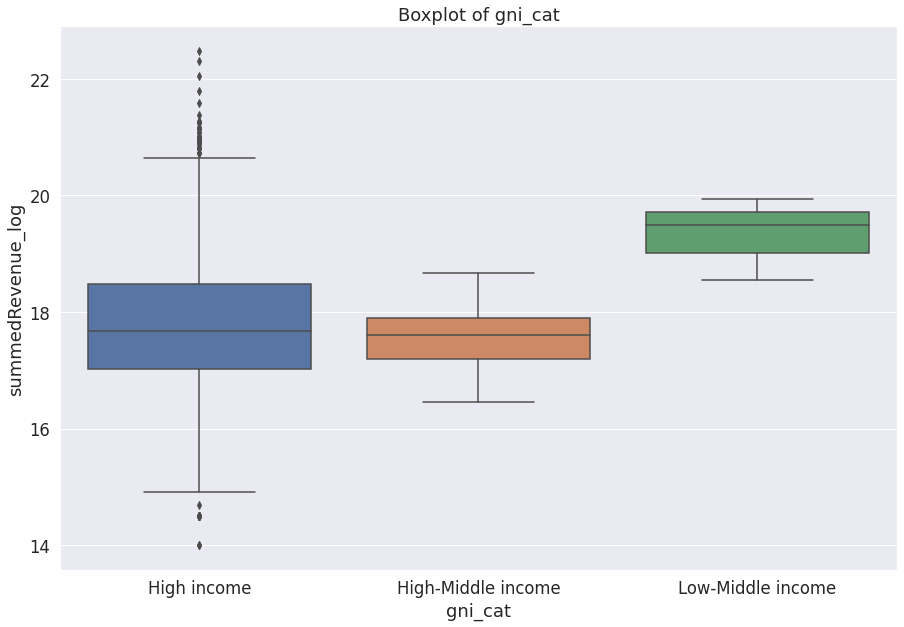

In [52]:
make_boxplot('gni_cat')

Low-middle income countries have the highet median money spent interestingly. However, high income countries have the widest distribution of money spent.

## Frequency Tables and Plots

In [11]:
for c in cat_df.columns:
    ICD.display((pd.crosstab(index=df[c], columns='count') .sort_values("count", ascending = False)))
pd.crosstab(index=df["channelGrouping"], columns='count') .sort_values("count", ascending = False)

col_0,count
geoNetwork.country,
United States,1282
Other,28
Canada,25


col_0,count
channelGrouping,
Referral,644
Organic Search,376
Direct,223
Paid Search,60
Display,20
Social,12


col_0,count
device.browser,
Chrome,1186
Safari,102
Other,47


col_0,count
device.operatingSystem,
iOS,800
Windows,261
Chrome OS,120
Linux,102
Android,52


col_0,count
device.deviceCategory,
desktop,1208
mobile,105
tablet,22


col_0,count
geoNetwork.continent,
Americas,1317
Europe,9
Asia,7
Oceania,2


col_0,count
trafficSource.source,
mall.googleplex.com,616
google,434
(direct),223
Other,62


col_0,count
trafficSource.medium,
referral,656
organic,376
(none),223
cpc,60
cpm,20


col_0,count
trafficSource.adContent,
Google Merchandise Collection,12
{KeyWord:Google Branded Gear},2
Display Ad created 11/17/14,1
Swag with Google Logos,1
{KeyWord:Google Men's T-Shirts},1
{KeyWord:Want Google Stickers?},1


col_0,count
device.isMobile,
False,1208
True,127


col_0,count
gni_cat,
High income,1324
High-Middle income,8
Low-Middle income,3


col_0,count
channelGrouping,
Referral,644
Organic Search,376
Direct,223
Paid Search,60
Display,20
Social,12


In [12]:
def count_plot(c):
  fig, ax = plt.subplots()
  fig.set_size_inches(30, 8)
  cntplt = sns.countplot(data=df, x=c)
  cntplt.set_title("Count Plot of " + c)

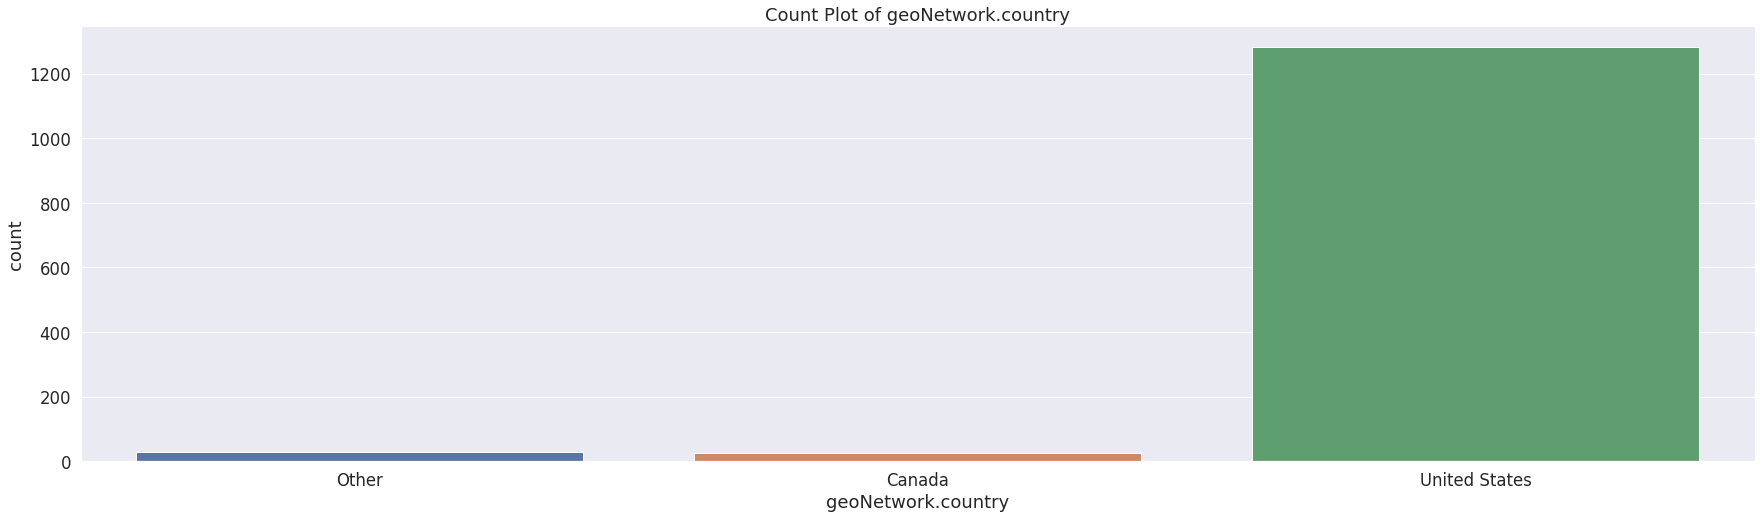

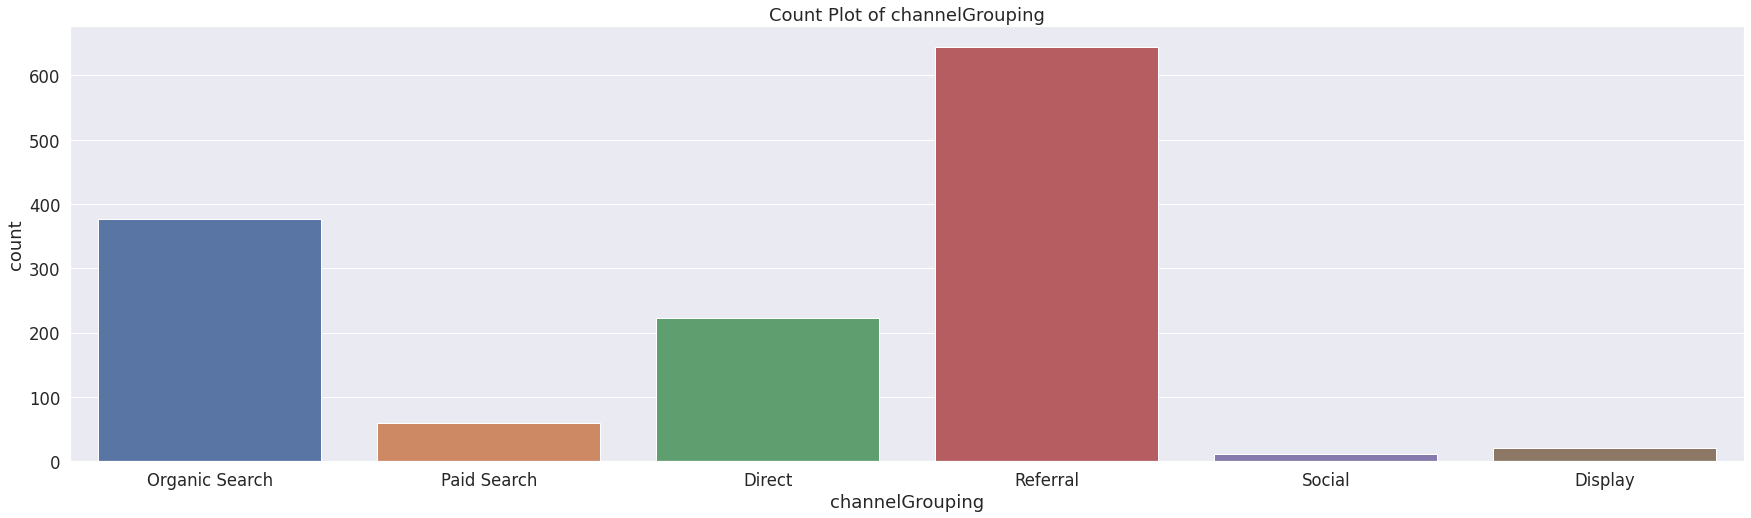

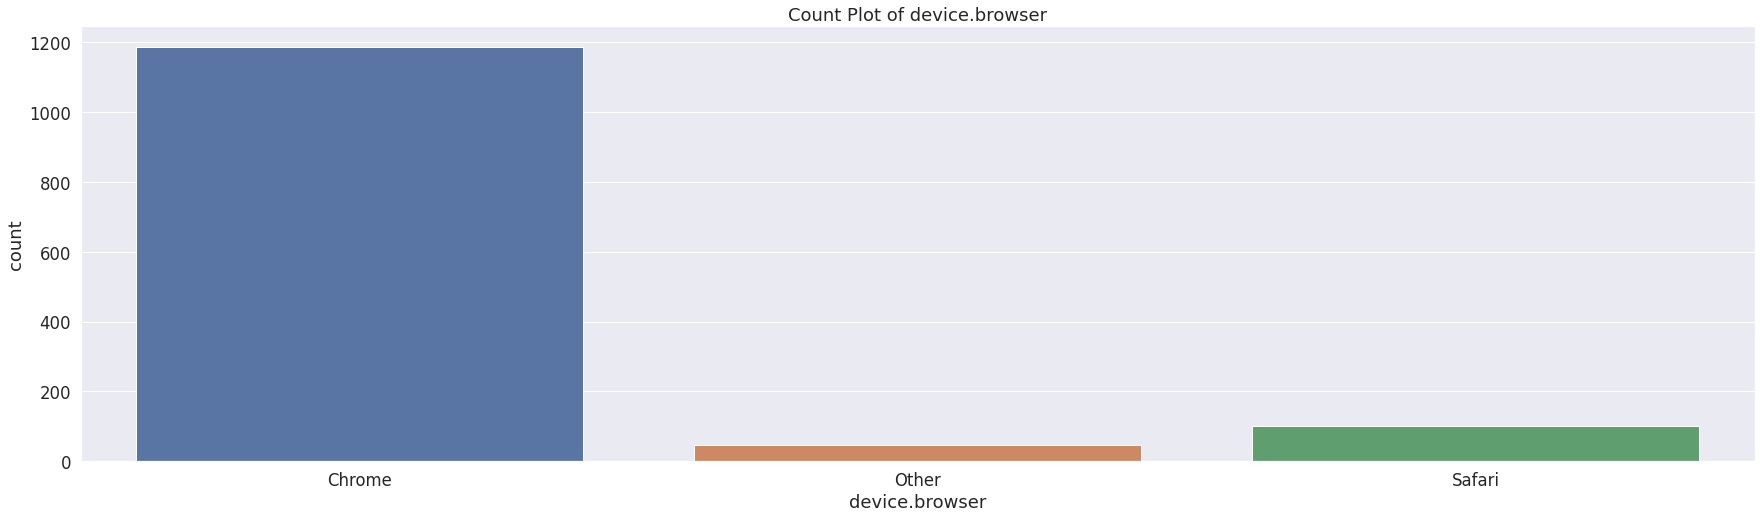

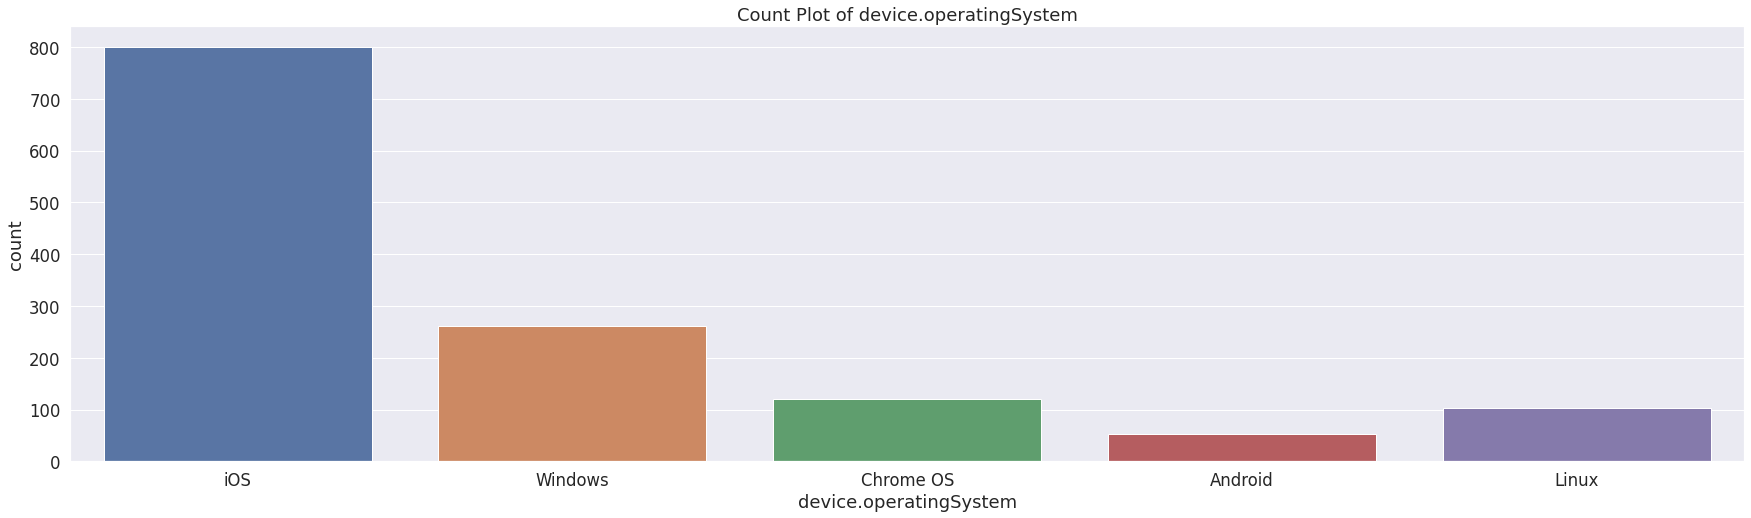

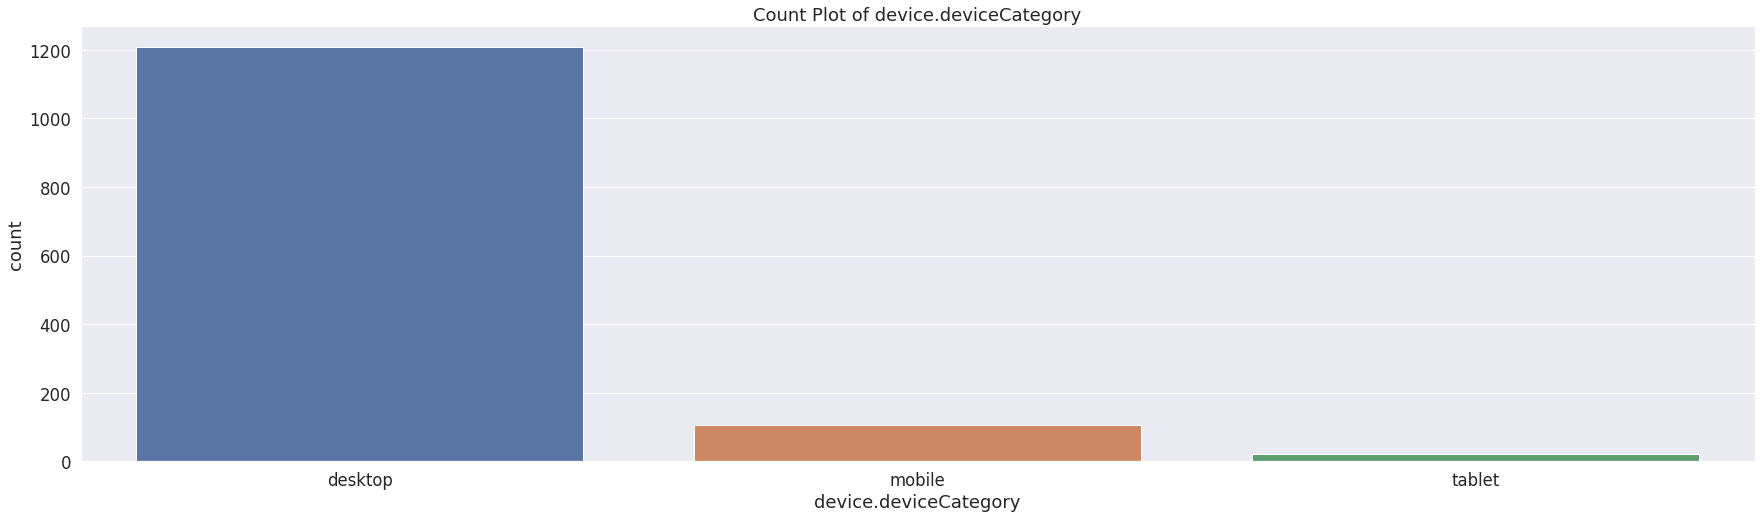

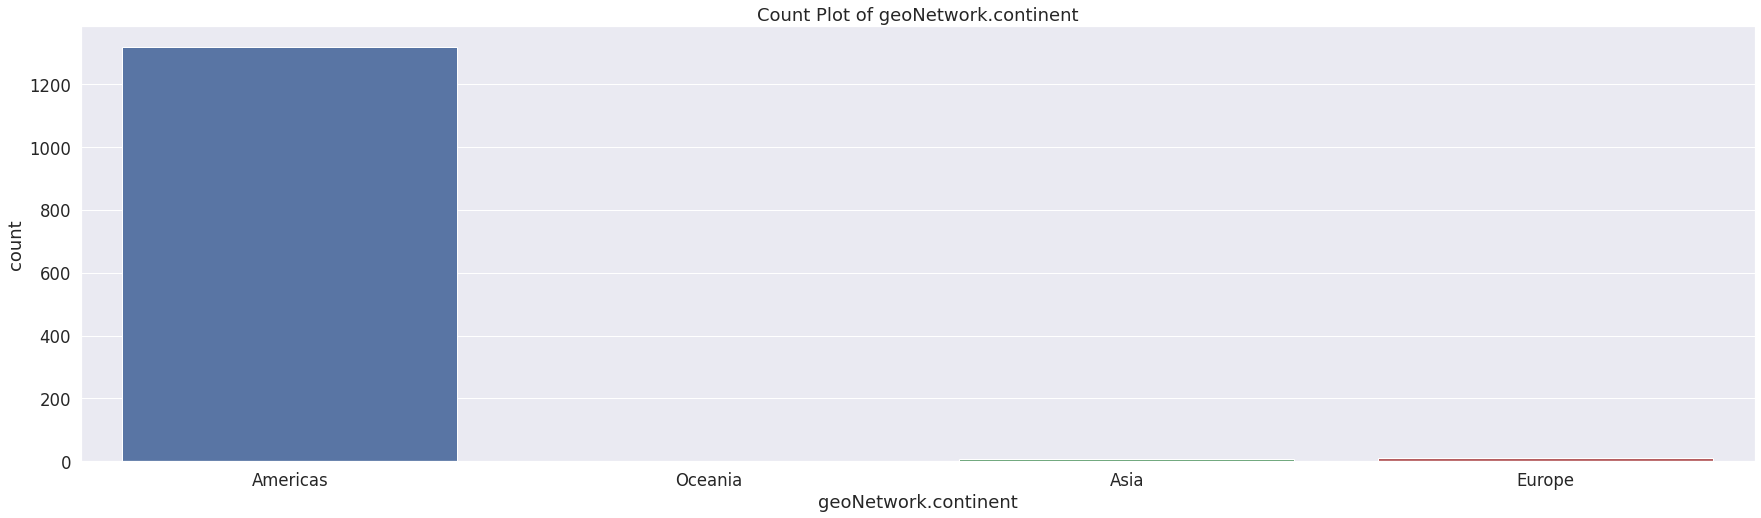

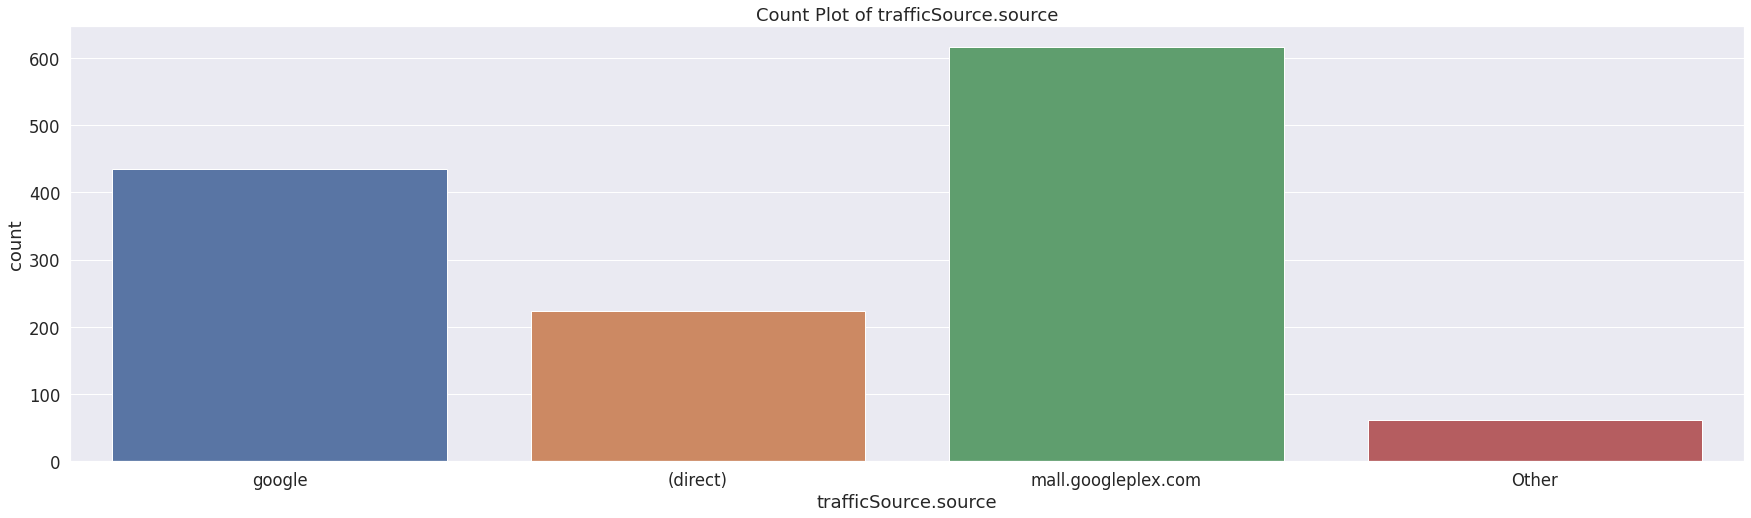

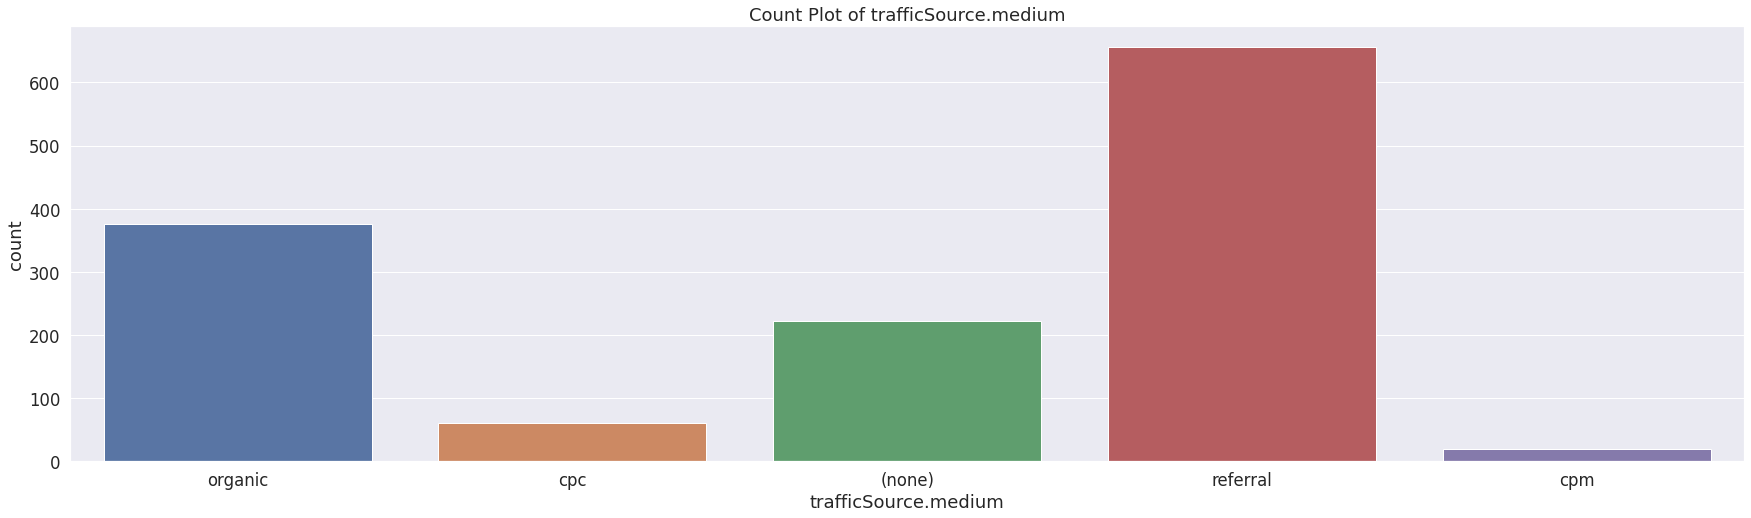

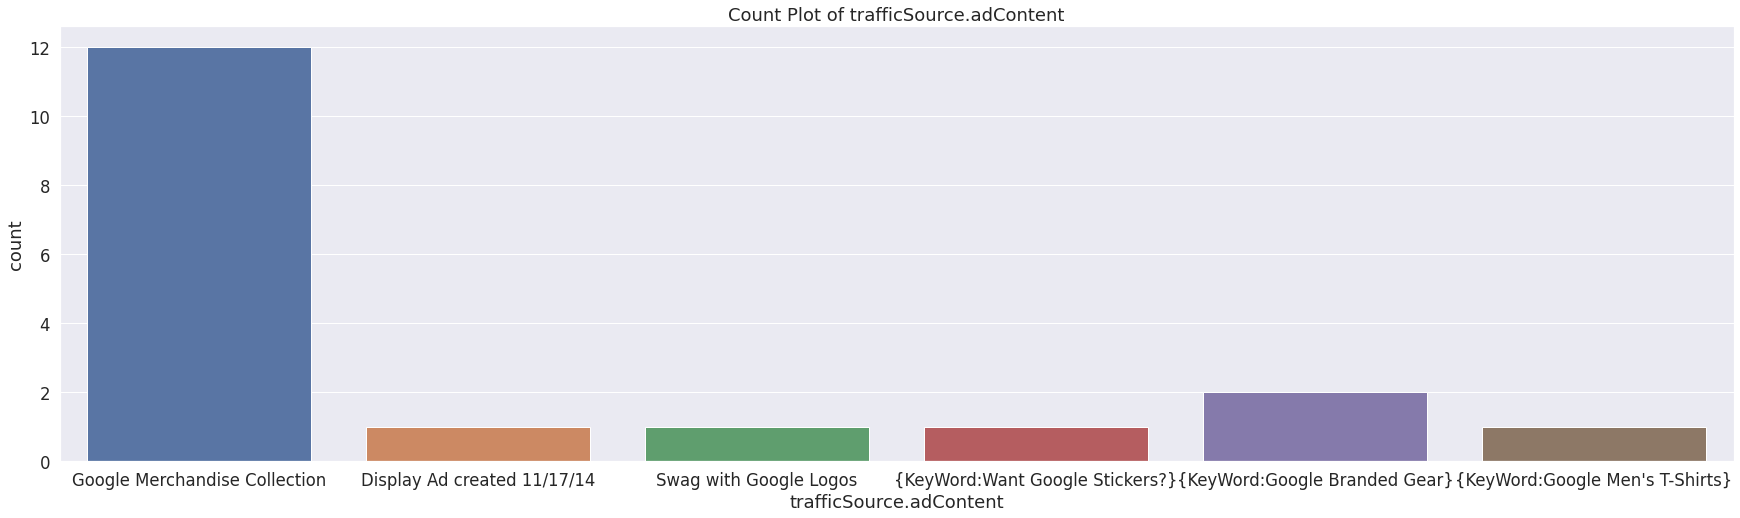

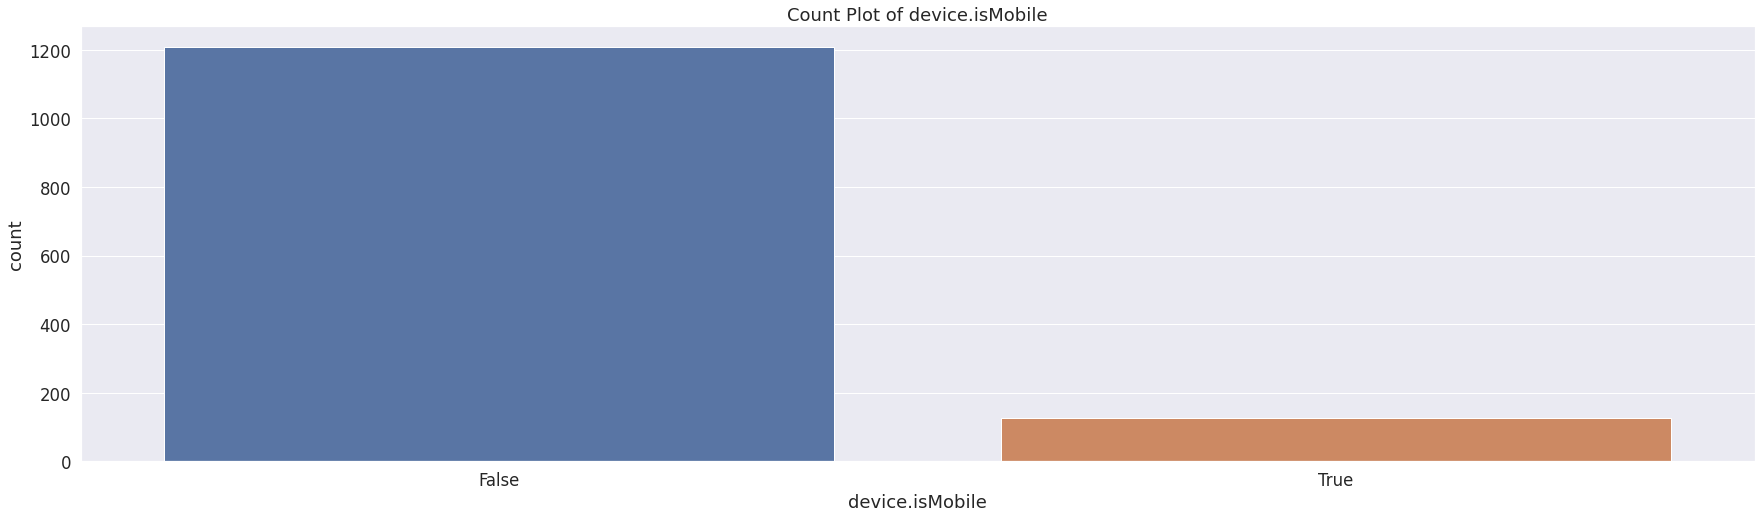

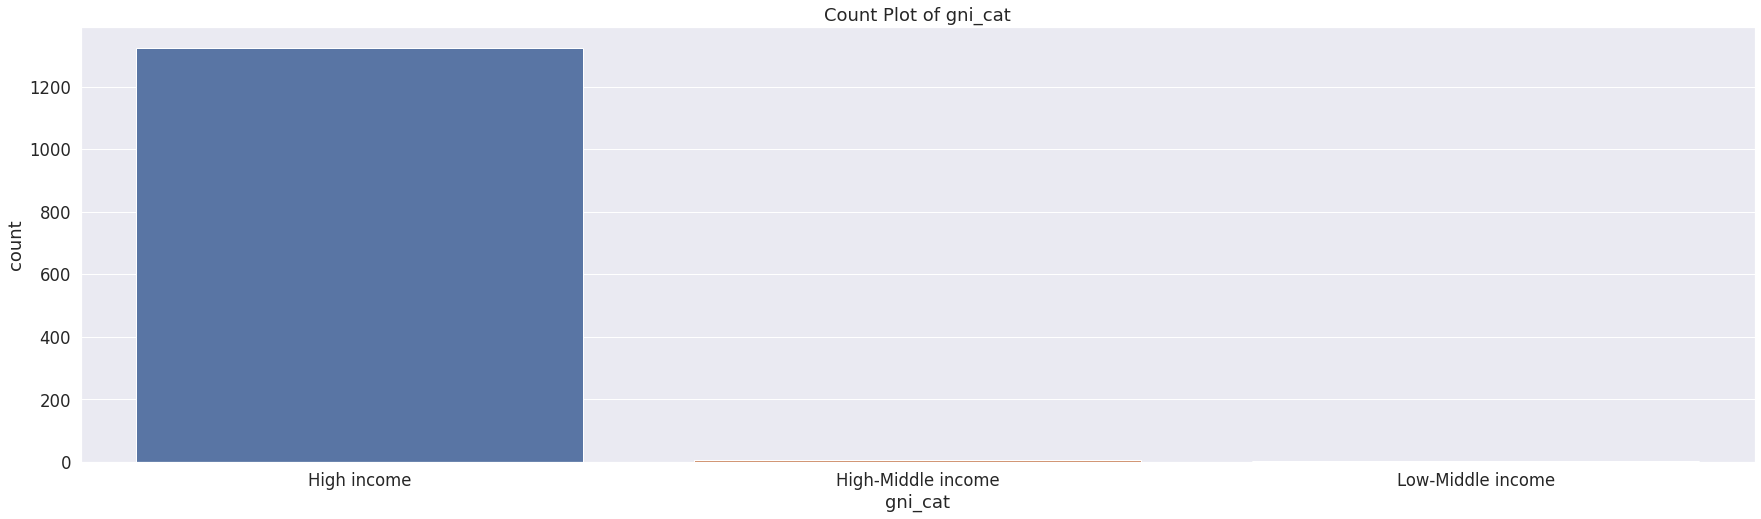

In [13]:
for c in cat_df.columns:
  count_plot(c)

As we can see above, a lot of these variables are imbalanced.

## Barplots

In [30]:
def barplt(c):
  plt.figure(figsize=(12, 6))

  df.groupby(c).summedRevenue.mean().plot.bar()
  plt.title('Average summedRevenue by ' + c, fontsize=16)
  plt.ylabel('Dollars', fontsize=14)
  plt.xlabel(c, fontsize=14)

  plt.show()

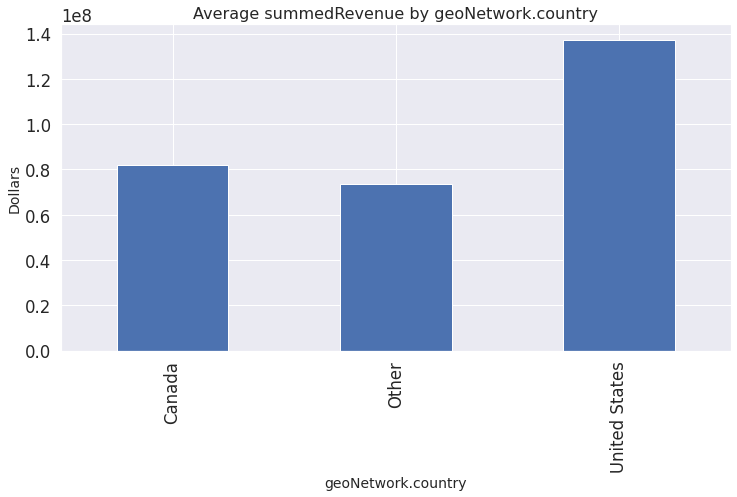

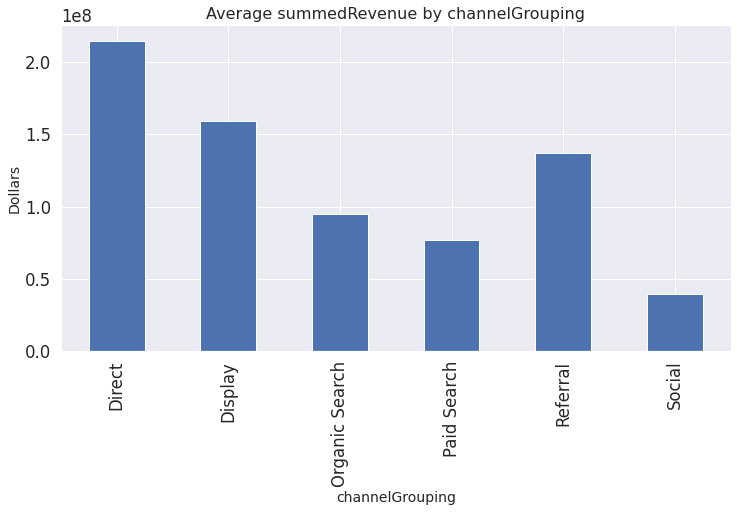

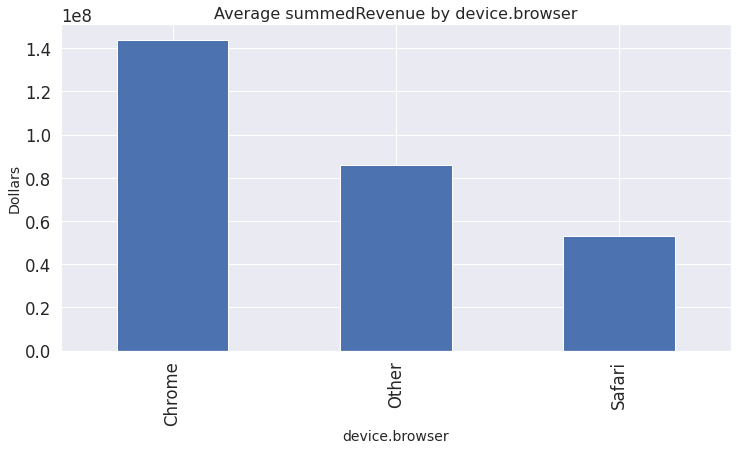

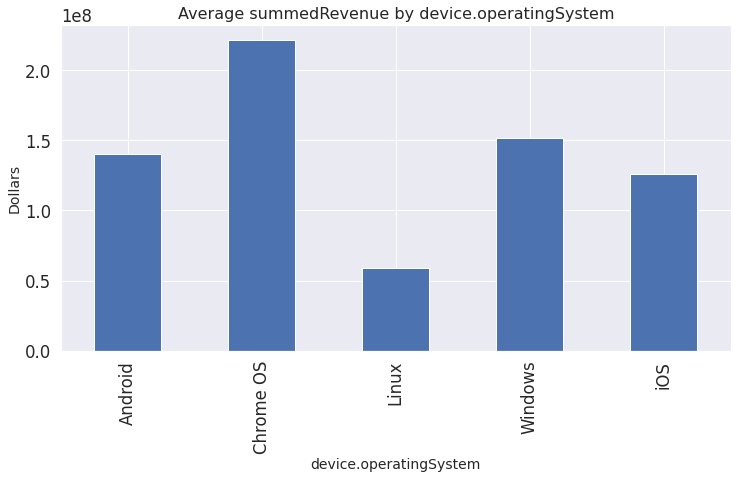

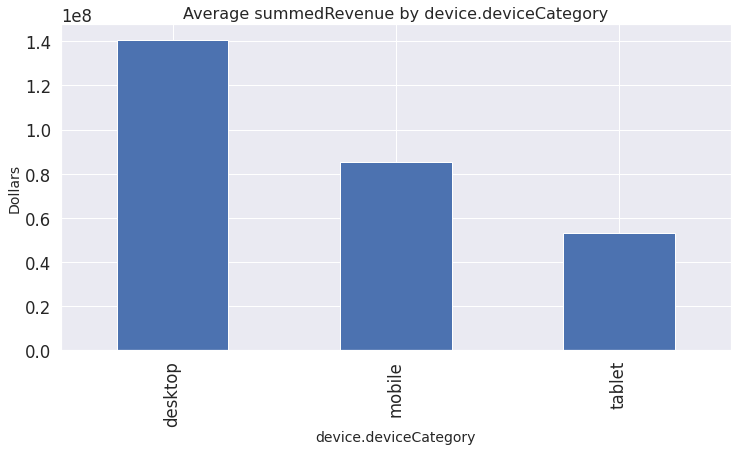

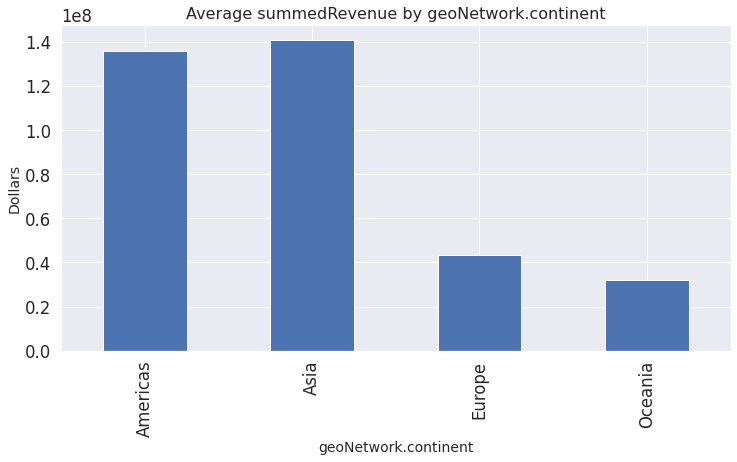

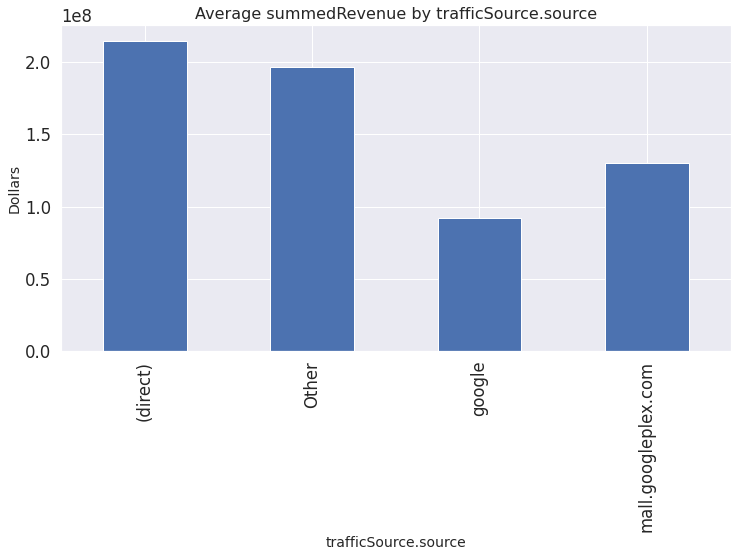

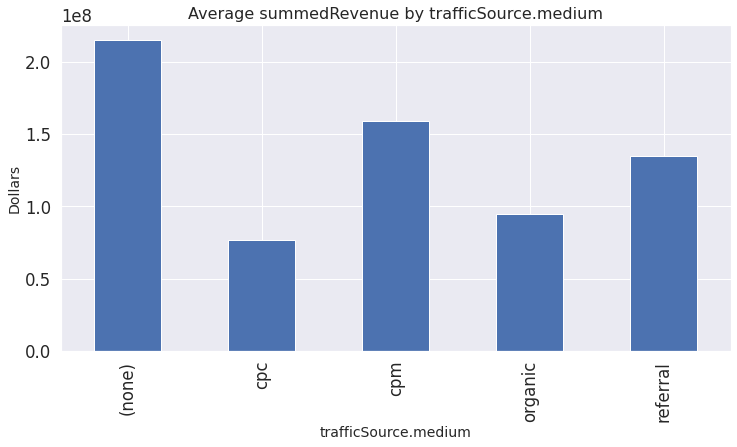

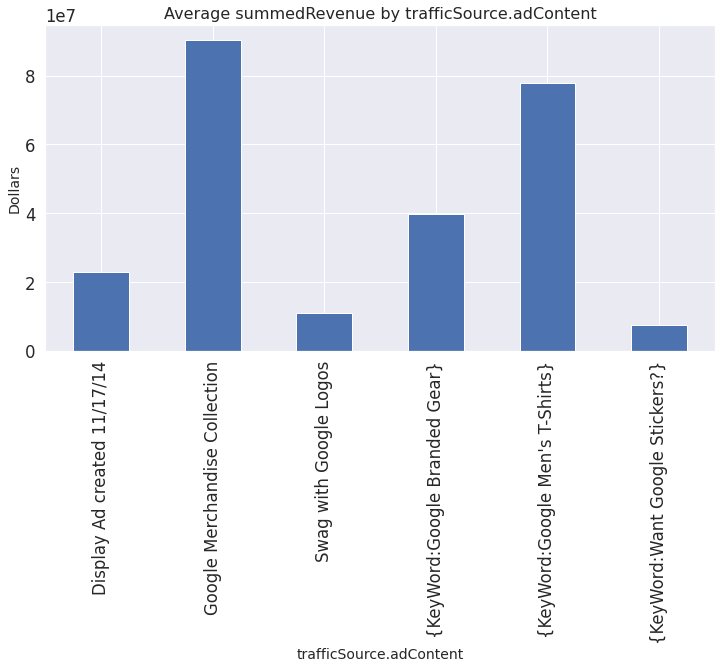

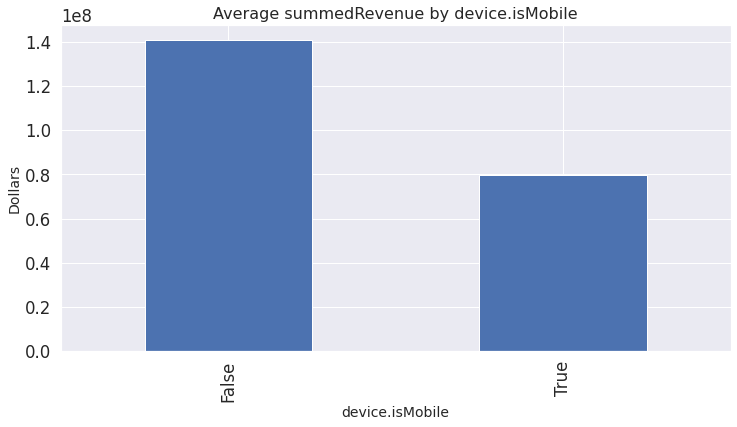

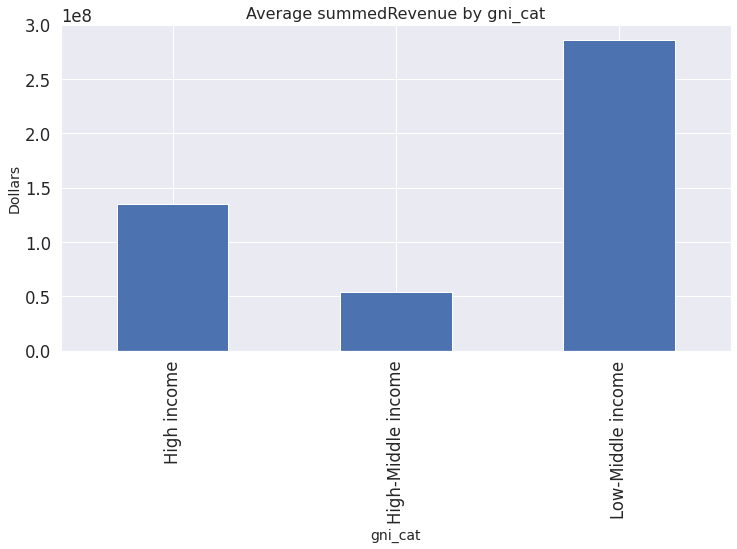

In [31]:
for c in cat_df.columns:
  barplt(c)

## Scatterplots

Text(0.5, 1.0, 'Scatter Plot of totals.hits and totals.pageviews')

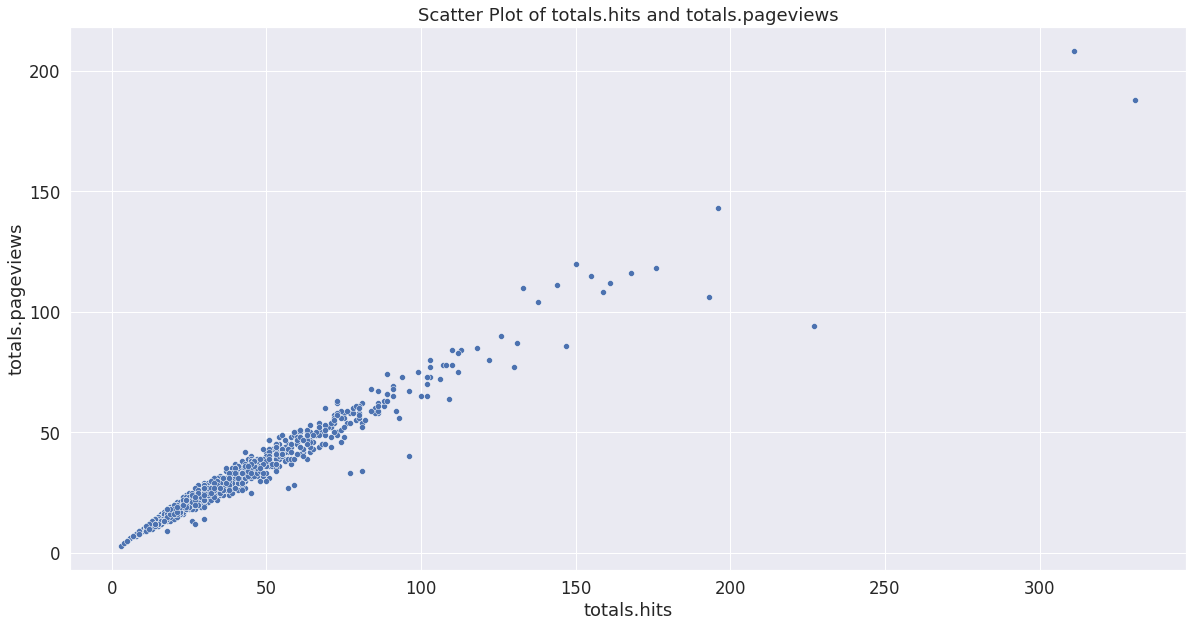

In [16]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
sctr = sns.scatterplot(data=df, x='totals.hits', y='totals.pageviews')
sctr.set_title("Scatter Plot of totals.hits and totals.pageviews")

It seems like there is a linear relationship between `totals.pageviews` and `totals.hits`, which makes intuitive sense.

In [17]:
def scatterplt(c):
  fig, ax = plt.subplots()
  fig.set_size_inches(20, 10)
  sctr = sns.scatterplot(data=df, x=c, y='summedRevenue_log')
  sctr.set_title("Scatter Plot of " + c + " and Log of Summed Revenue")

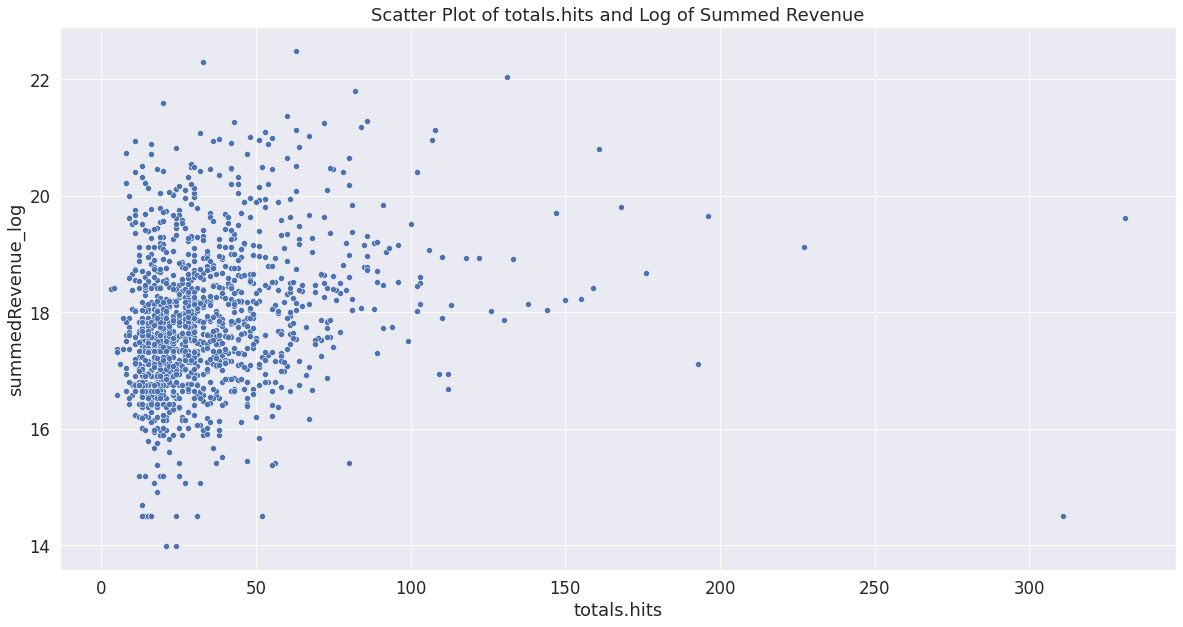

In [18]:
scatterplt('totals.hits')

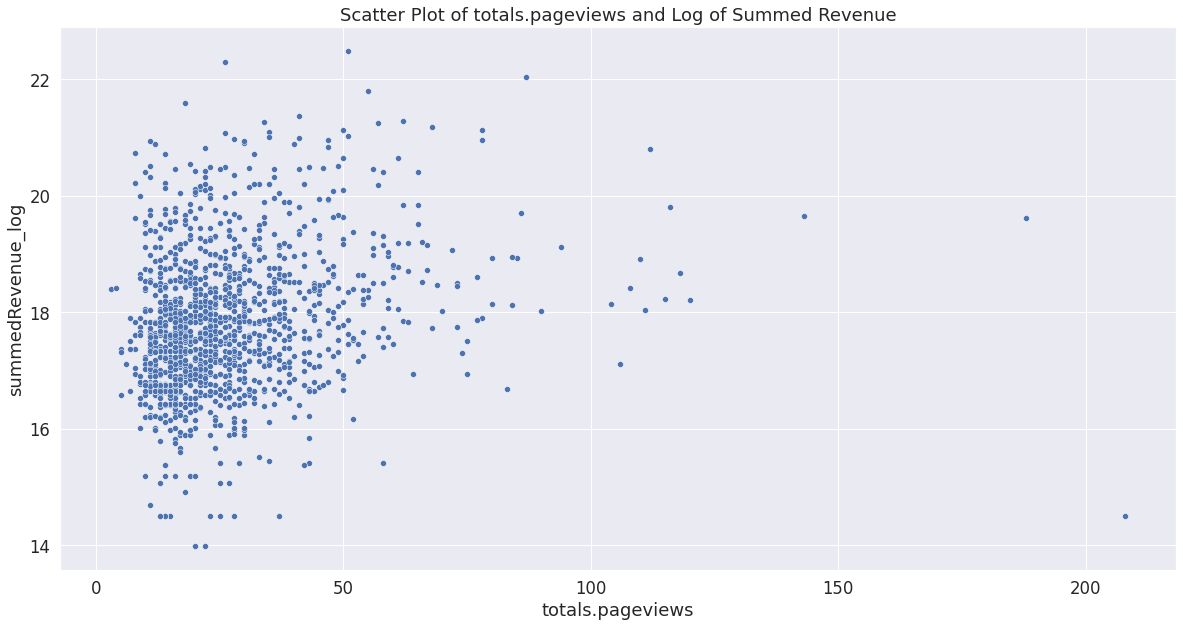

In [19]:
scatterplt('totals.pageviews')

## Exploring Date

In [20]:
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')

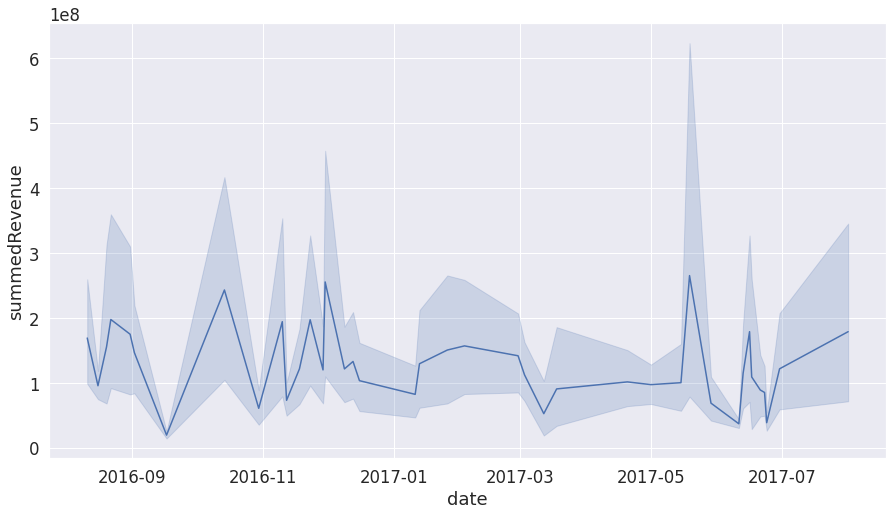

In [21]:
plt.figure(figsize = (15,8))
sns.lineplot(x = 'date', y = 'summedRevenue', data = df)

## Exploring the Distribution of Revenue by Other Variables

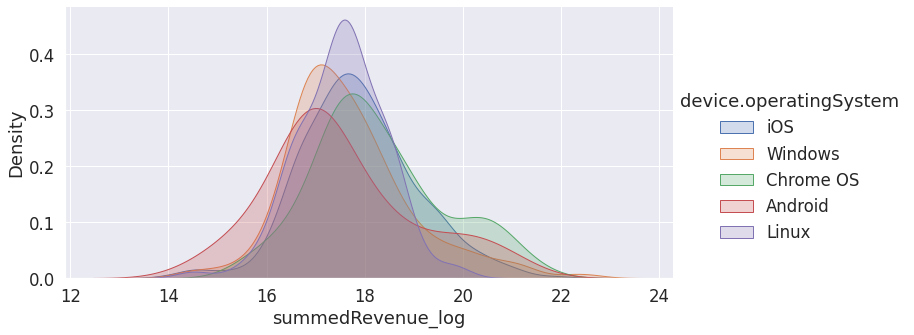

In [23]:
(sns.FacetGrid(df[(df['device.operatingSystem']\
                   .isin(df['device.operatingSystem']\
                         .value_counts()[:6].index.values)) & df['summedRevenue_log'] > 0], hue='device.operatingSystem', height=5, aspect=2)
.map(sns.kdeplot, 'summedRevenue_log', shade=True).add_legend()
)

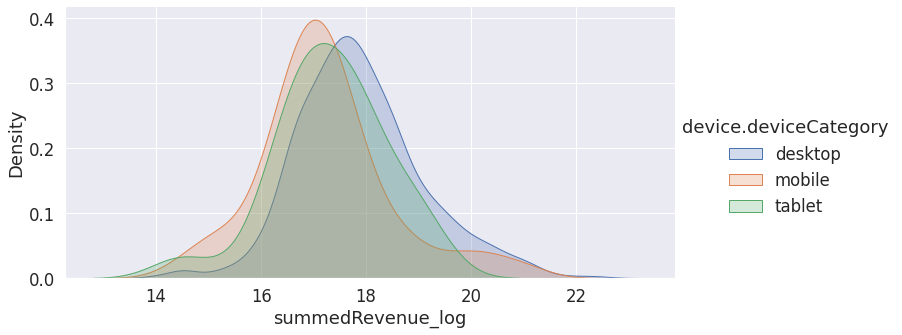

In [24]:
(sns.FacetGrid(df[df['summedRevenue_log'] > 0],
               hue='device.deviceCategory', height=5, aspect=2)
  .map(sns.kdeplot, 'summedRevenue_log', shade=True)
 .add_legend()
)
plt.show()

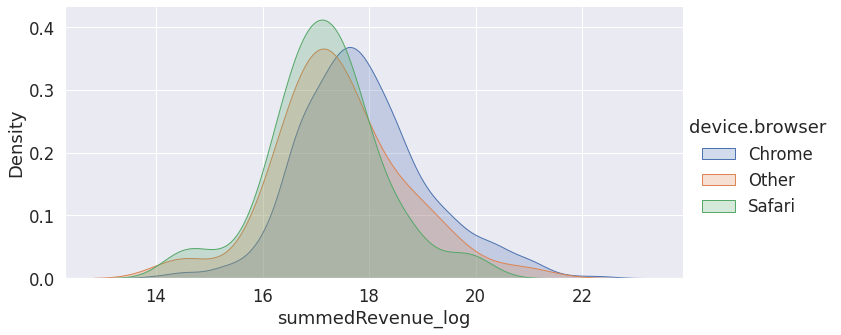

In [25]:
(sns.FacetGrid(df[df['summedRevenue_log'] > 0],
               hue='device.browser', height=5, aspect=2)
  .map(sns.kdeplot, 'summedRevenue_log', shade=True)
 .add_legend()
)
plt.show()